In [1]:
import imageio
import imgaug as ia
from imgaug import augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from imgaug.augmentables.batches import Batch
import numpy as np
import matplotlib.pyplot as plt

## Data Augmentation

In order to make the model not overfit on the dataset we need to apply data augmentations techniques.
By default extrayolo supports [imgaug]() as data augmentation framework.
The example below shows an example of image with 2 bounding boxes.


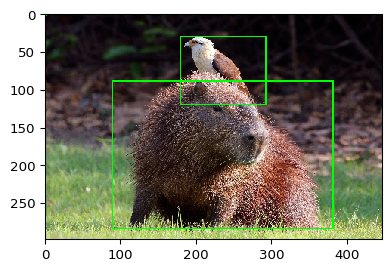

In [2]:
image = imageio.imread("https://upload.wikimedia.org/wikipedia/commons/8/8e/Yellow-headed_caracara_%28Milvago_chimachima%29_on_capybara_%28Hydrochoeris_hydrochaeris%29.JPG")
image = ia.imresize_single_image(image, (298, 447))

bbs = BoundingBoxesOnImage([
    BoundingBox(x1=0.2*447, x2=0.85*447, y1=0.3*298, y2=0.95*298),
    BoundingBox(x1=0.4*447, x2=0.65*447, y1=0.1*298, y2=0.4*298),
    BoundingBox(0,0,0,0)
], shape=image.shape)

ia.imshow(bbs.draw_on_image(image, size=2))

In order to perform data augmentation on the image we can create a pipeline of transformations.

In [3]:
pipeline = iaa.Sequential([
    iaa.Crop(percent=(0, 0.2)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    iaa.Sometimes(
        0.2,
        iaa.Grayscale(alpha=(0.0, 1.0))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.LinearContrast((0.75, 1.5)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.8, 1.5), "y": (0.8, 1.5)},
        translate_percent={"x": (-0.3, 0.3), "y": (-0.3, 0.3)},
        rotate=(-30, 30),
        shear=(-12, 12)
    ),
], random_order=True)

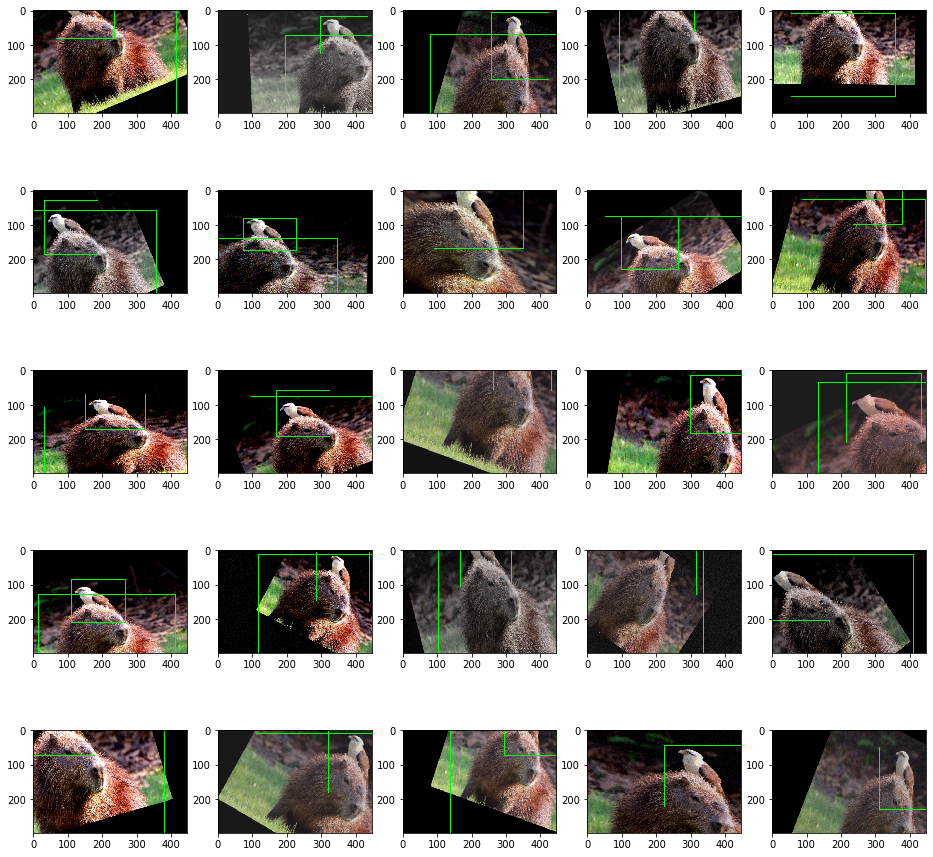

In [4]:
fig, axes = plt.subplots(5,5, figsize=(16,16))
axes = axes.flatten()

for ax in axes:
    image_aug, bbs_aug = pipeline(image=image, bounding_boxes=bbs)
#     print(np.count_nonzero(image_aug < 0))
    ax.imshow(bbs_aug.draw_on_image(np.clip(image_aug,0, None), size=2))
    bbs_aug.to_xyxy_array()

plt.show()

We can see that the images is augmented such as the boxes.
Given a set of transformations they can be applied to a batch of images.
We create a batch of images

In [5]:
images = np.array([image, image])
bbss = [bbs, bbs]
batch = Batch(images=images, bounding_boxes=bbss)

In [6]:
pipeline = iaa.Sequential([
    iaa.GammaContrast(1.5),
    iaa.Affine(rotate=(-90, 90))
])

and perform data augmentation on the batch

In [7]:
batch_processed = pipeline.augment_batch(batch)
batch_processed.images_aug.shape

/Users/fumarolaf/miniconda3/envs/dl/lib/python3.7/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Method `Sequential.augment_batch()` is deprecated. Use `augment_batch_()` instead. `augment_batch()` was renamed to `augment_batch_()` as it changes all `*_unaug` attributes of batches in-place. Note that `augment_batch_()` has now a `parents` parameter. Calls of the style `augment_batch(batch, hooks)` must be changed to `augment_batch(batch, hooks=hooks)`.
  warn_deprecated(msg, stacklevel=3)


(2, 298, 447, 3)

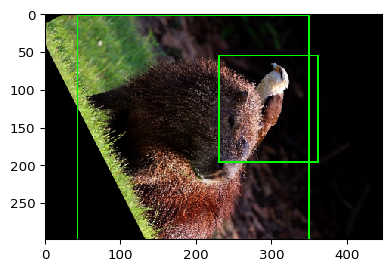

[[  42.94179      2.4848936  348.00412    349.43832  ]
 [ 229.58095     54.77084    360.16602    195.02307  ]
 [ 253.90475   -117.887245   253.90475   -117.887245 ]]


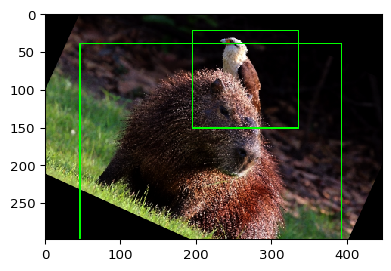

[[ 45.978065  39.323105 390.5972   335.75543 ]
 [195.1043    21.98099  333.80573  149.56241 ]
 [ 81.52142  -79.02486   81.52142  -79.02486 ]]


In [8]:
for image_aug, bbs_aug in zip(batch_processed.images_aug, batch_processed.bounding_boxes_aug):
    ia.imshow(bbs_aug.draw_on_image(image_aug, size=2))
    print(bbs_aug.to_xyxy_array())